<a href="https://colab.research.google.com/github/Saraldedv/CCMACLRL_PROJECT_COM222/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RESNET WHOLE FLOW FOR EASY RERUN

## Install dependencies

In [ ]:
pip install tensorflow opencv-python roboflow scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

## prepare dataset

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="kllPn6XsBsLz8K2iQx6i")
project = rf.workspace("deep-learning-rp9gw").project("final-proj-jpjtg")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to final-proj-3 in yolov8:: 100%|██████████| 25292/25292 [00:03<00:00, 8230.63it/s] 


In [ ]:
import os
import shutil
import yaml

# Set correct dataset directory
dataset_dir = "final-proj-3"
images_dir = os.path.join(dataset_dir, "train", "images")
labels_dir = os.path.join(dataset_dir, "train", "labels")
yaml_path = os.path.join(dataset_dir, "data.yaml")

# Read class names from data.yaml
with open(yaml_path, 'r') as stream:
    data = yaml.safe_load(stream)
    class_names = data['names']

# Create output directory and subfolders per class
output_dir = "final-project"
os.makedirs(output_dir, exist_ok=True)
for class_name in class_names:
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

# Convert YOLO format to classification folders
for label_file in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, label_file)

    with open(label_path, "r") as f:
        first_line = f.readline().strip()
        if not first_line:
            continue  # Skip empty label files
        class_idx = int(first_line.split()[0])

    image_file = label_file.replace(".txt", ".jpg")
    src = os.path.join(images_dir, image_file)
    dst = os.path.join(output_dir, class_names[class_idx], image_file)

    if os.path.exists(src):
        shutil.copy(src, dst)


In [ ]:
print("Class names:", class_names)


Class names: ['glass', 'leaf', 'metal', 'paper', 'plastic']


## mapping the waste to its classifications

In [ ]:
waste_category = {
    "glass": ("non-biodegradable", "recyclable"),
    "leaf": ("biodegradable", "non-recyclable"),   # typically organic waste
    "metal": ("non-biodegradable", "recyclable"),
    "paper": ("biodegradable", "recyclable"),
    "plastic": ("non-biodegradable", "recyclable"),
}


## loading the dataset for training

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
import numpy as np

batch_size = 32
img_size = (224, 224)

# Load datasets with batching
train_ds = image_dataset_from_directory(
    "final-proj-3",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)

val_ds = image_dataset_from_directory(
    "final-proj-3",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)

class_names = train_ds.class_names

# Gaussian blur function
def apply_gaussian_blur(image):
    # input is already a numpy array here, so no need to call .numpy()
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    blurred = blurred.astype(np.float32) / 255.0
    return blurred

# Preprocessing function (works on unbatched images)
def preprocess_with_blur(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.numpy_function(apply_gaussian_blur, [image], tf.float32)
    image.set_shape([224, 224, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Unbatch, preprocess, then batch again
train_ds = train_ds.unbatch()
train_ds = train_ds.map(preprocess_with_blur).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# For validation dataset, just normalize and batch again
val_ds = val_ds.unbatch()
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, [224, 224]) / 255.0, y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)


Found 12640 files belonging to 3 classes.
Using 10112 files for training.
Found 12640 files belonging to 3 classes.
Using 2528 files for validation.


## building the resnet-50 and mobilenetv2 fusion model

In [ ]:
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model

input_tensor = Input(shape=(224, 224, 3))

# Feature extractors
resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=input_tensor)
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=input_tensor)

# Freeze base models
resnet.trainable = False
mobilenet.trainable = False

# Combine features
resnet_out = GlobalAveragePooling2D()(resnet.output)
mobilenet_out = GlobalAveragePooling2D()(mobilenet.output)
combined = Concatenate()([resnet_out, mobilenet_out])

# Fully connected layers
x = Dense(256, activation="relu")(combined)
x = Dense(128, activation="relu")(x)
output = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=input_tensor, outputs=output)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,731,203 (101.97 MB)

 Trainable params: 885,507 (3.38 MB)

 Non-trainable params: 25,845,696 (98.59 MB)

## training the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,           # Wait 3 epochs without improvement before stopping
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,           # Reduce LR by half
    patience=2,           # Wait 2 epochs without improvement
    min_lr=1e-6
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,            # Increase max epochs so early stopping can kick in properly
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
    316/Unknown 58s 108ms/step - accuracy: 0.9026 - loss: 0.3639

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


316/316 ━━━━━━━━━━━━━━━━━━━━ 74s 160ms/step - accuracy: 0.9027 - loss: 0.3638 - val_accuracy: 0.9138 - val_loss: 0.2915 - learning_rate: 0.0010
Epoch 2/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 64s 141ms/step - accuracy: 0.9168 - loss: 0.2735 - val_accuracy: 0.9142 - val_loss: 0.2832 - learning_rate: 0.0010
Epoch 3/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 82s 141ms/step - accuracy: 0.9185 - loss: 0.2605 - val_accuracy: 0.9173 - val_loss: 0.2814 - learning_rate: 0.0010
Epoch 4/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 142s 330ms/step - accuracy: 0.9204 - loss: 0.2452 - val_accuracy: 0.9189 - val_loss: 0.2911 - learning_rate: 0.0010
Epoch 5/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - accuracy: 0.9203 - loss: 0.2352 - val_accuracy: 0.9106 - val_loss: 0.3005 - learning_rate: 0.0010
Epoch 6/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 105s 141ms/step - accuracy: 0.9236 - loss: 0.2214 - val_accuracy: 0.9138 - val_loss: 0.3195 - learning_rate: 5.0000e-04


## plotting of accuracy and training loss

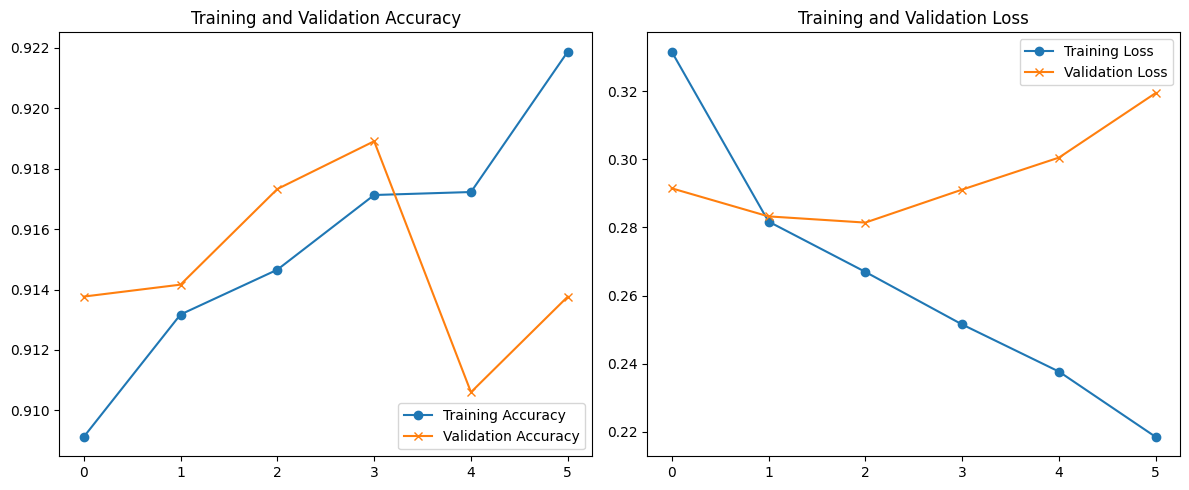

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()


## heat map

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


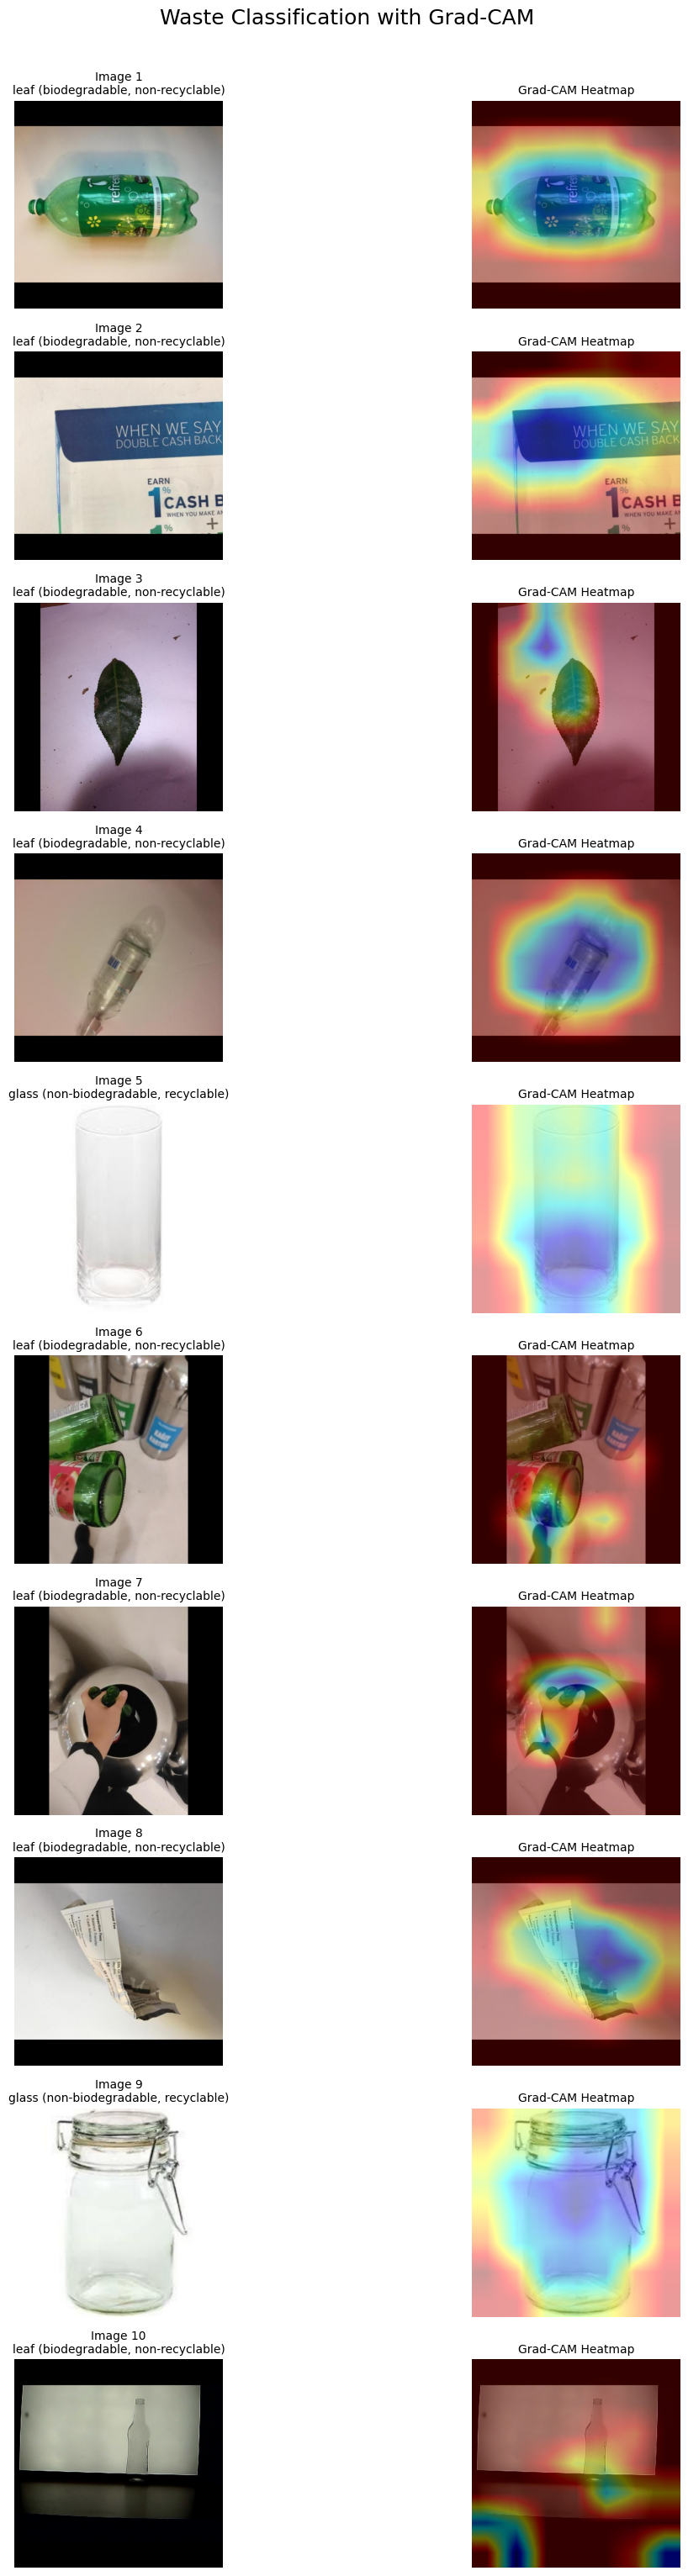

In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

# === Define class names based on your model's output layer ===
# Ensure this matches the model's output (length & order)
class_names = ["glass", "leaf", "metal", "paper", "plastic"]  # Adjust if necessary
# Define waste classification categories
waste_category = {
    "glass": ("non-biodegradable", "recyclable"),
    "leaf": ("biodegradable", "non-recyclable"),   # typically organic waste
    "metal": ("non-biodegradable", "recyclable"),
    "paper": ("biodegradable", "recyclable"),
    "plastic": ("non-biodegradable", "recyclable"),
}


# Set path to test images
test_images_dir = '/content/final-proj-3/test/images'
all_images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_images = random.sample(all_images, 10)

# === Load your model ===
# Make sure your model is already loaded before running this script
# Example: model = tf.keras.models.load_model('your_model_path.h5')

# Name of last convolutional layer for Grad-CAM
last_conv_layer_name = "Conv_1"  # Adjust based on your model architecture

# Build Grad-CAM model
grad_model = Model(
    inputs=[model.inputs],
    outputs=[model.get_layer(last_conv_layer_name).output, model.output]
)

# === Grad-CAM heatmap function ===
def get_gradcam_heatmap(img_array, class_index):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

# === Prediction and heatmap generation ===
def predict_with_heatmap(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None, None, None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img_rgb, (224, 224))
    input_tensor = resized / 255.0
    input_tensor = np.expand_dims(input_tensor, axis=0)

    preds = model.predict(input_tensor)
    class_index = np.argmax(preds)

    if class_index >= len(class_names):
        print(f"[Warning] class_index {class_index} out of range for class_names.")
        class_label = "Unknown"
    else:
        class_label = class_names[class_index]

    category = waste_category.get(class_label.lower(), ("Unknown", "Unknown"))

    # Grad-CAM heatmap
    heatmap = get_gradcam_heatmap(input_tensor, class_index)
    heatmap_resized = cv2.resize(heatmap, (img_rgb.shape[1], img_rgb.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_rgb, 0.6, heatmap_colored, 0.4, 0)

    label_text = f"{class_label.lower()} ({category[0]}, {category[1]})"
    return img_rgb, superimposed, label_text

# === Visualization ===
fig, axes = plt.subplots(10, 2, figsize=(14, 30))  # 10 rows, 2 columns

for i in range(10):
    img_file = random_images[i]
    img_path = os.path.join(test_images_dir, img_file)
    orig, heatmap, label = predict_with_heatmap(img_path)

    if orig is not None and heatmap is not None:
        axes[i][0].imshow(orig)
        axes[i][0].set_title(f"Image {i+1}\n{label}", fontsize=10)
        axes[i][0].axis('off')

        axes[i][1].imshow(heatmap)
        axes[i][1].set_title("Grad-CAM Heatmap", fontsize=10)
        axes[i][1].axis('off')
    else:
        axes[i][0].set_visible(False)
        axes[i][1].set_visible(False)

plt.tight_layout()
plt.suptitle("Waste Classification with Grad-CAM", fontsize=18, y=1.02)
plt.show()


## image testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


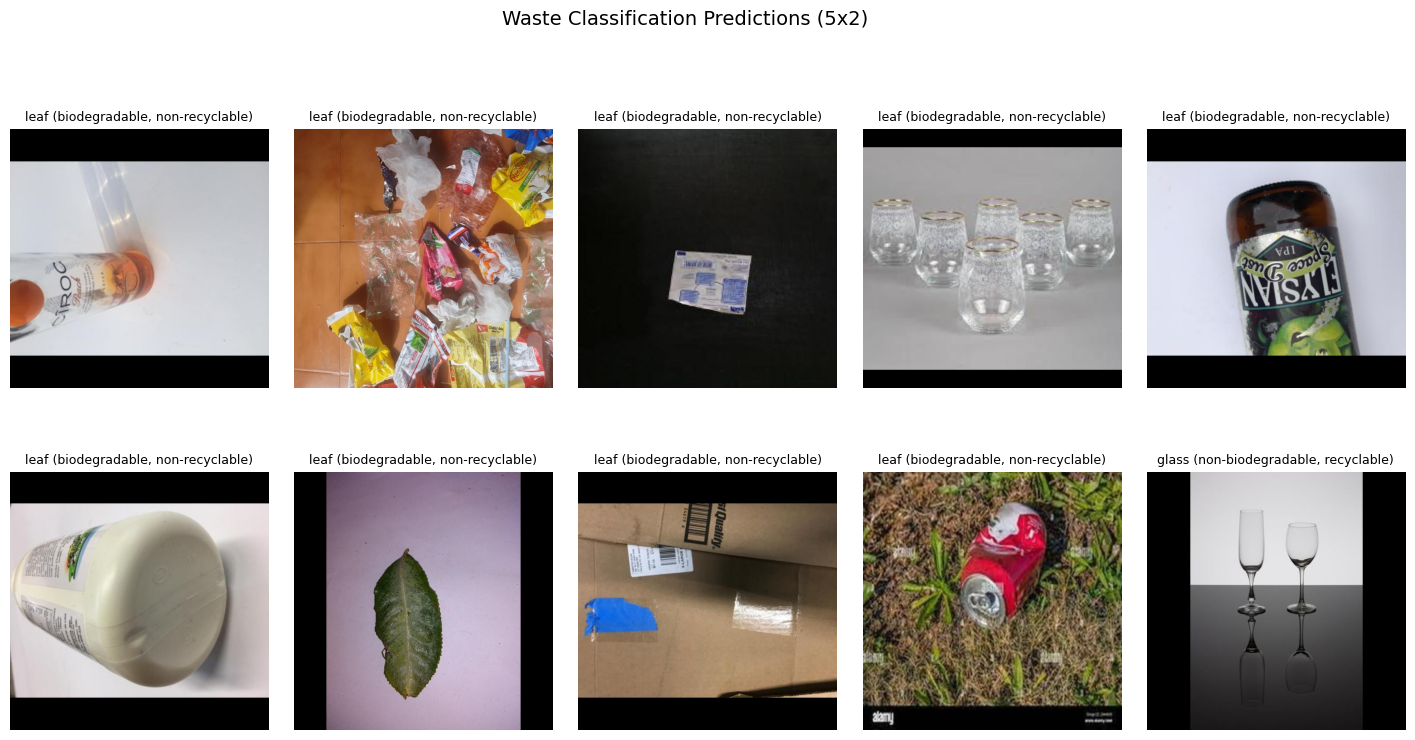

In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

# Define waste classification categories
waste_category = {
    "glass": ("non-biodegradable", "recyclable"),
    "leaf": ("biodegradable", "non-recyclable"),   # typically organic waste
    "metal": ("non-biodegradable", "recyclable"),
    "paper": ("biodegradable", "recyclable"),
    "plastic": ("non-biodegradable", "recyclable"),
}

# Path to test images
test_images_dir = '/content/final-proj-3/test/images'
all_images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_images = random.sample(all_images, 10)

# Predict and collect image + label
def predict_and_collect(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error loading: {img_path}")
        return None, None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(img_rgb, (224, 224))
    input_tensor = resized_img / 255.0
    input_tensor = np.expand_dims(input_tensor, axis=0)

    pred = model.predict(input_tensor)
    class_idx = np.argmax(pred)
    class_label = class_names[class_idx]
    category = waste_category.get(class_label.lower(), ("Unknown", "Unknown"))

    return img_rgb, f"{class_label.lower()} ({category[0]}, {category[1]})"

# Create 5x2 grid (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(18, 8))  # Adjust figure size
axes = axes.flatten()

for i, img_file in enumerate(random_images):
    img_path = os.path.join(test_images_dir, img_file)
    img_rgb, label_text = predict_and_collect(img_path)

    if img_rgb is not None:
        axes[i].imshow(img_rgb)
        axes[i].set_title(label_text, fontsize=9)
        axes[i].axis('off')
    else:
        axes[i].set_visible(False)

# Hide any unused axes (in case of loading errors)
for j in range(len(random_images), len(axes)):
    axes[j].set_visible(False)

# Tighter spacing
plt.subplots_adjust(wspace=0.1, hspace=0.25)
fig.suptitle("Waste Classification Predictions (5x2)", fontsize=14, y=1.02)
plt.show()


# 82% ACCURACY YOLO WHOLE FLOW FOR EASY RUN

In [ ]:
pip install ultralytics opencv-python matplotlib roboflow

## install dependencies

In [ ]:
import os
import numpy as np
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2

## preparing classnames

In [ ]:
# === Define Class Names ===
class_names = ['glass', 'leaf', 'metal', 'paper', 'plastic']
num_classes = len(class_names)

waste_category = {
    "glass": ("non-biodegradable", "recyclable"),
    "leaf": ("biodegradable", "non-recyclable"),   # typically organic waste
    "metal": ("non-biodegradable", "recyclable"),
    "paper": ("biodegradable", "recyclable"),
    "plastic": ("non-biodegradable", "recyclable"),
}

## data preparation

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="kllPn6XsBsLz8K2iQx6i")
project = rf.workspace("deep-learning-rp9gw").project("final-proj-jpjtg")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
image_dir = '/content/final-proj-3/train/images'
label_dir = '/content/final-proj-3/train/labels'
image_size = (208, 208)  # width, height

## loading images and annotations

In [ ]:
X = []
y_class = []
y_bbox = []

for filename in os.listdir(image_dir):
    if filename.endswith(('.jpg', '.png')):
        img_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        img = img / 255.0  # Normalize

        # Check if label file exists
        if not os.path.exists(label_path):
            continue

        with open(label_path, 'r') as f:
            lines = f.readlines()
        if not lines:
            continue

        # Use only the first object in the label file
        line = lines[0].strip().split()
        if len(line) == 5:
            cls_id = int(line[0])  # class id from label file
            bbox = list(map(float, line[1:]))

            X.append(img)
            y_class.append(cls_id)
            y_bbox.append(bbox)

X = np.array(X)
y_class = to_categorical(y_class, num_classes=num_classes)
y_bbox = np.array(y_bbox)

## splitting of dataset

In [ ]:
X_temp, X_test, y_cls_temp, y_cls_test, y_bbox_temp, y_bbox_test = train_test_split(
    X, y_class, y_bbox, test_size=0.1, random_state=42, stratify=y_class
)

X_train, X_val, y_cls_train, y_cls_val, y_bbox_train, y_bbox_val = train_test_split(
    X_temp, y_cls_temp, y_bbox_temp, test_size=0.1111, random_state=42
)

## train log

In [ ]:
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback

class TrainingLogger(Callback):
    def __init__(self, X_val, y_val, class_names, log_file='training_log.txt'):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.class_names = class_names
        self.log_file = log_file

        # Initialize log file
        with open(self.log_file, 'w') as f:
            f.write("Epoch\tVal_Loss\tVal_Accuracy\tVal_F1_Score\n")

    def on_epoch_end(self, epoch, logs=None):
        y_true = np.argmax(self.y_val, axis=1)
        y_pred_probs = self.model.predict(self.X_val, verbose=0)[0]  # [0] for classification output
        y_pred = np.argmax(y_pred_probs, axis=1)

        f1 = f1_score(y_true, y_pred, average='weighted')
        acc = logs.get('val_class_output_accuracy', 0)
        loss = logs.get('val_loss', 0)

        print(f"\n📘 Epoch {epoch + 1} Validation Log:")
        print(f"   - val_loss: {loss:.4f}")
        print(f"   - val_accuracy: {acc:.4f}")
        print(f"   - val_f1_score: {f1:.4f}\n")

        with open(self.log_file, 'a') as f:
            f.write(f"{epoch + 1}\t{loss:.4f}\t{acc:.4f}\t{f1:.4f}\n")

logger = TrainingLogger(X_val, y_cls_val, class_names)

## bulding of model

In [ ]:
input_layer = layers.Input(shape=(image_size[1], image_size[0], 3))  # (height, width, channels)

x = layers.Conv2D(64, (3, 3), activation='relu')(input_layer)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(x)
bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)

model = models.Model(inputs=input_layer, outputs=[class_output, bbox_output])

model.compile(
    optimizer='adam',
    loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
    metrics={'class_output': 'accuracy'}
)

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 60, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 58, 58,    │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 29, 29,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 27, 27,    │     18,464 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 13, 13,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 5408)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    692,352 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 5)         │        645 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │        516 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 713,769 (2.72 MB)

 Trainable params: 713,769 (2.72 MB)

 Non-trainable params: 0 (0.00 B)

## training of model

In [ ]:
history = model.fit(
    X_train,
    {'class_output': y_cls_train, 'bbox_output': y_bbox_train},
    epochs=10,
    batch_size=32,
    validation_data=(X_val, {'class_output': y_cls_val, 'bbox_output': y_bbox_val}),
    callbacks=[logger]
)

Epoch 1/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - bbox_output_loss: 0.0281 - class_output_accuracy: 0.5389 - class_output_loss: 1.1283 - loss: 1.1563
📘 Epoch 1 Validation Log:
   - val_loss: 0.7328
   - val_accuracy: 0.7184
   - val_f1_score: 0.7158

287/287 ━━━━━━━━━━━━━━━━━━━━ 82s 264ms/step - bbox_output_loss: 0.0280 - class_output_accuracy: 0.5392 - class_output_loss: 1.1277 - loss: 1.1557 - val_bbox_output_loss: 0.0159 - val_class_output_accuracy: 0.7184 - val_class_output_loss: 0.7176 - val_loss: 0.7328
Epoch 2/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - bbox_output_loss: 0.0161 - class_output_accuracy: 0.7104 - class_output_loss: 0.7249 - loss: 0.7410
📘 Epoch 2 Validation Log:
   - val_loss: 0.6468
   - val_accuracy: 0.7507
   - val_f1_score: 0.7315

287/287 ━━━━━━━━━━━━━━━━━━━━ 69s 220ms/step - bbox_output_loss: 0.0161 - class_output_accuracy: 0.7104 - class_output_loss: 0.7248 - loss: 0.7410 - val_bbox_output_loss: 0.0143 - val_class_output_accuracy: 0.7507 - val_cla

## evaluate model

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# True labels for test set
y_true = np.argmax(y_cls_test, axis=1)

# Predictions for test set
pred_probs, _ = model.predict(X_test, verbose=0)
y_pred = np.argmax(pred_probs, axis=1)

# Classification report and metrics
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Classification Report:

              precision    recall  f1-score   support

       glass       0.60      0.67      0.64       146
        leaf       0.97      0.99      0.98       274
       metal       0.86      0.76      0.81       254
       paper       0.79      0.85      0.82       232
   plastic         0.78      0.75      0.76       241

    accuracy                           0.82      1147
   macro avg       0.80      0.80      0.80      1147
weighted avg       0.82      0.82      0.82      1147


Accuracy: 0.8187
F1 Score: 0.8192
Precision: 0.8222
Recall: 0.8187


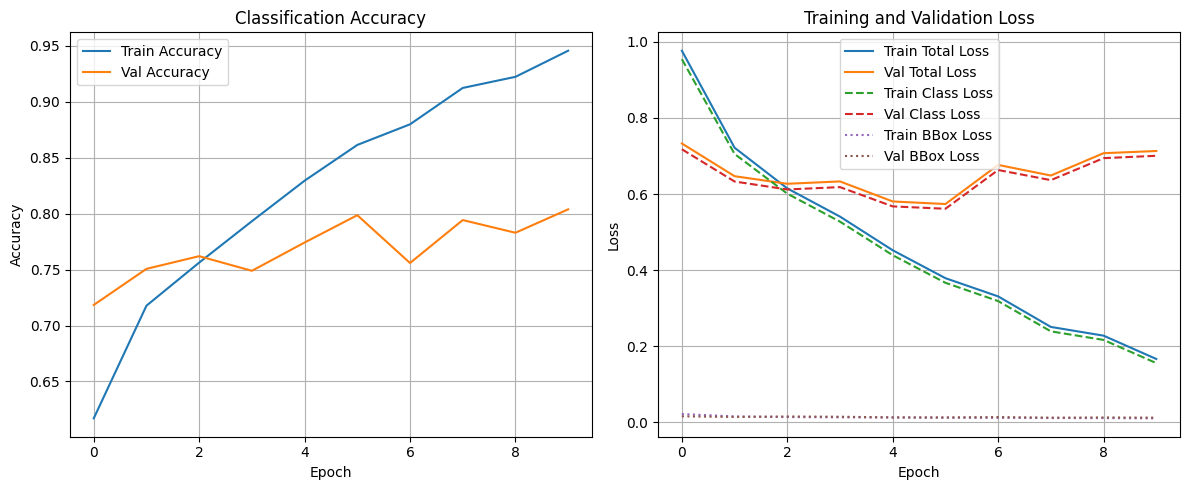

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Val Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.plot(history.history['class_output_loss'], label='Train Class Loss', linestyle='--')
plt.plot(history.history['val_class_output_loss'], label='Val Class Loss', linestyle='--')
plt.plot(history.history['bbox_output_loss'], label='Train BBox Loss', linestyle=':')
plt.plot(history.history['val_bbox_output_loss'], label='Val BBox Loss', linestyle=':')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_9']]
Received: inputs=Tensor(shape=(1, 60, 60, 3))


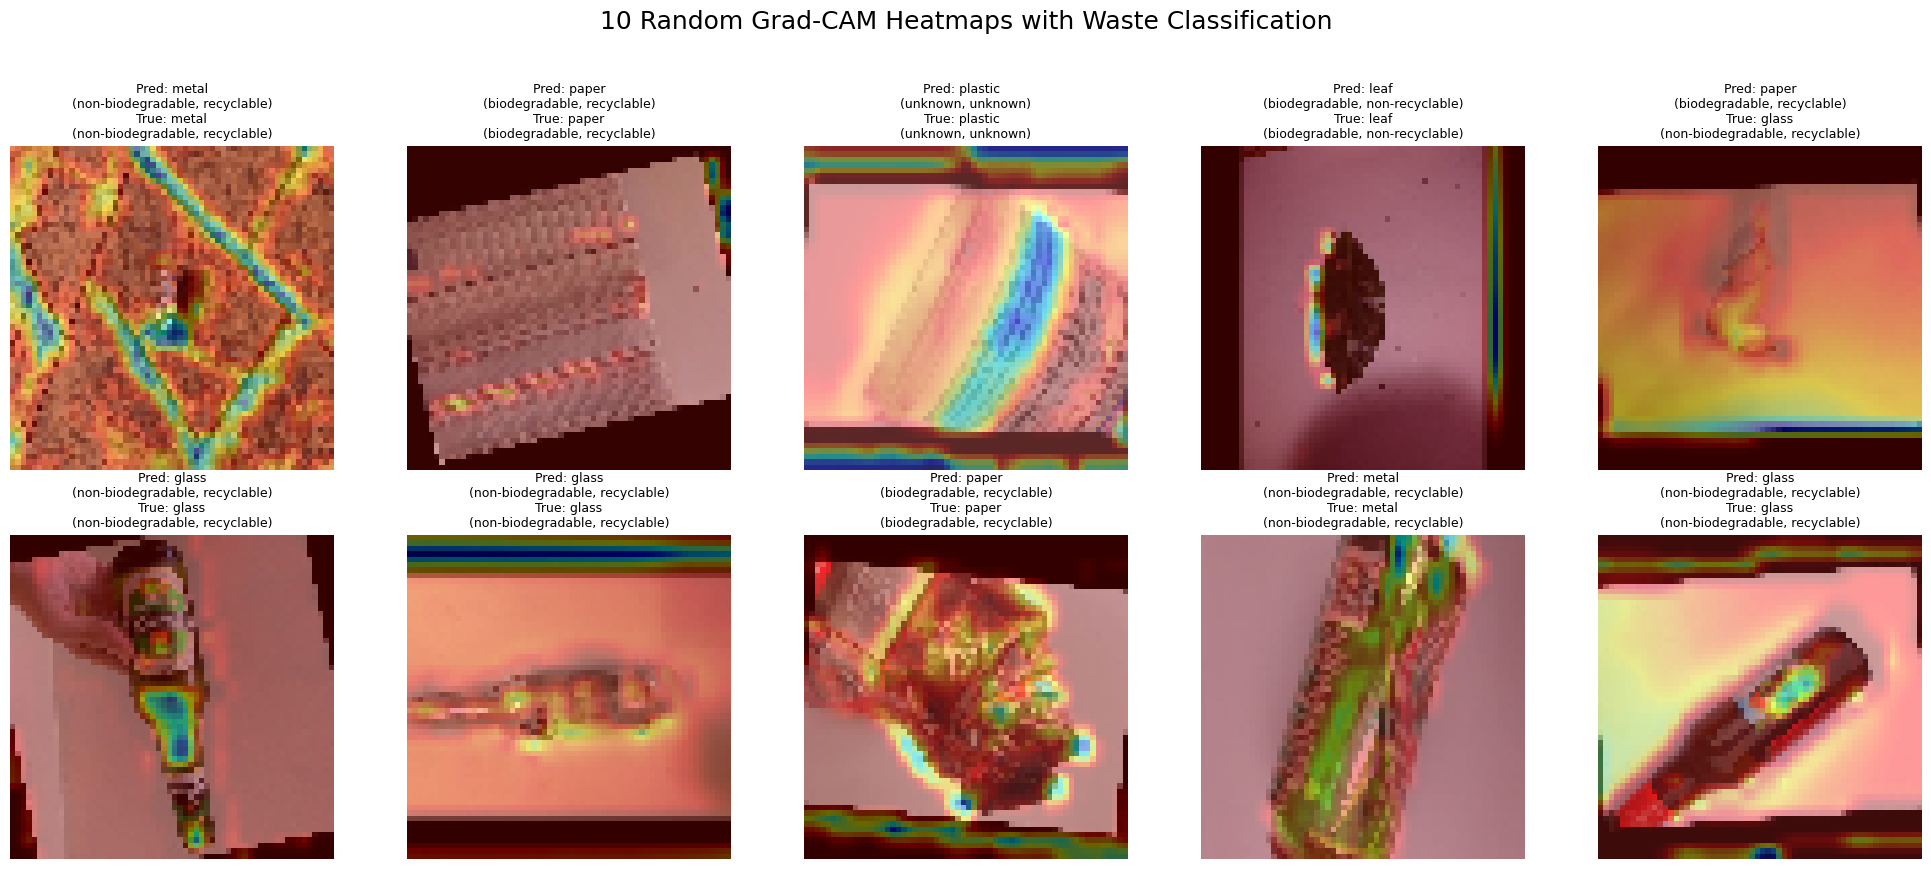

In [ ]:
from tensorflow.keras.models import Model
import random

def find_last_conv_layer(model):
    # Go through layers in reverse order
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")


def make_gradcam_heatmap(img_array, model, class_index, last_conv_layer_name):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output[0]]
    )

    img_array = np.expand_dims(img_array, axis=0)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
    conv_outputs = conv_outputs[0].numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap

true_class_indices = np.argmax(y_cls_test, axis=1)
indices = random.sample(range(len(X_test)), 10)

plt.figure(figsize=(20, 8))  # 2 rows × 5 columns

for i, idx in enumerate(indices):
    img = X_test[idx]
    true_cls_index = true_class_indices[idx]
    true_cls_name = class_names[true_cls_index]

    # Predict
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_cls_index = np.argmax(pred[0])
    pred_cls_name = class_names[pred_cls_index]

    # Waste categories
    pred_cat = waste_category.get(pred_cls_name, ("unknown", "unknown"))
    true_cat = waste_category.get(true_cls_name, ("unknown", "unknown"))

    last_conv_layer_name = find_last_conv_layer(model)
    heatmap = make_gradcam_heatmap(img, model, pred_cls_index, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_uint8 = np.uint8(255 * img)
    superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    plt.subplot(2, 5, i + 1)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title(
        f"Pred: {pred_cls_name}\n({pred_cat[0]}, {pred_cat[1]})\n"
        f"True: {true_cls_name}\n({true_cat[0]}, {true_cat[1]})",
        fontsize=9
    )

plt.tight_layout()
plt.suptitle("10 Random Grad-CAM Heatmaps with Waste Classification", fontsize=18, y=1.08)
plt.show()

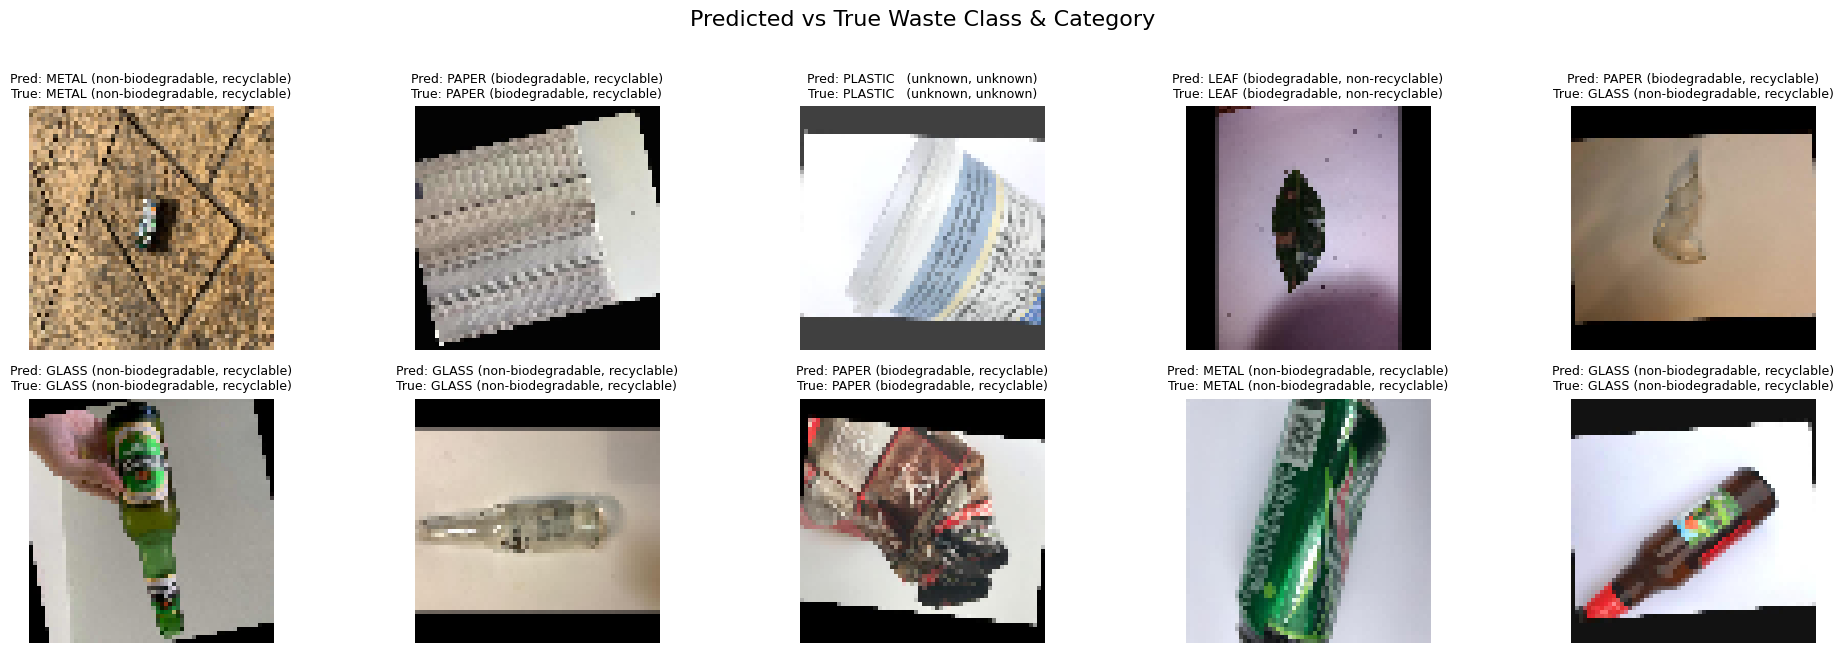

In [ ]:
plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    img = X_test[idx]

    # True class and category
    true_cls_index = true_class_indices[idx]
    true_class_name = class_names[true_cls_index]
    true_cat = waste_category.get(true_class_name, ("unknown", "unknown"))

    # Predicted class and category
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_cls_index = np.argmax(pred[0])
    pred_class_name = class_names[pred_cls_index]
    pred_cat = waste_category.get(pred_class_name, ("unknown", "unknown"))

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"Pred: {pred_class_name.upper()} ({pred_cat[0]}, {pred_cat[1]})\n"
        f"True: {true_class_name.upper()} ({true_cat[0]}, {true_cat[1]})",
        fontsize=9
    )

plt.tight_layout()
plt.suptitle("Predicted vs True Waste Class & Category", fontsize=16, y=1.08)
plt.show()

# YOLO NEW FOR EASY RUN

In [ ]:
!pip install ultralytics opencv-python matplotlib roboflow

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import cv2
import random

In [ ]:
# === Class and Category Definitions ===
class_names = ['glass', 'leaf', 'metal', 'paper', 'plastic']
num_classes = len(class_names)

waste_category = {
    "glass": ("non-biodegradable", "recyclable"),
    "leaf": ("biodegradable", "non-recyclable"),
    "metal": ("non-biodegradable", "recyclable"),
    "paper": ("biodegradable", "recyclable"),
    "plastic": ("non-biodegradable", "recyclable"),
}

# === Load Dataset ===
image_dir = '/content/final-proj-3/train/images'
label_dir = '/content/final-proj-3/train/labels'
image_size = (90, 90)  # width, height

In [ ]:
X, y_class, y_bbox = [], [], []

for filename in os.listdir(image_dir):
    if filename.endswith(('.jpg', '.png')):
        img_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")

        # Load and preprocess image
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        img = img / 255.0  # Normalize

        if not os.path.exists(label_path):
            continue

        with open(label_path, 'r') as f:
            lines = f.readlines()
        if not lines:
            continue

        # Take only first object in label file
        line = lines[0].strip().split()
        if len(line) == 5:
            cls_id = int(line[0])
            bbox = list(map(float, line[1:]))

            X.append(img)
            y_class.append(cls_id)
            y_bbox.append(bbox)

X = np.array(X)
y_class = to_categorical(y_class, num_classes=num_classes)
y_bbox = np.array(y_bbox)

# Split dataset
X_temp, X_test, y_cls_temp, y_cls_test, y_bbox_temp, y_bbox_test = train_test_split(
    X, y_class, y_bbox, test_size=0.1, random_state=42, stratify=y_class
)

X_train, X_val, y_cls_train, y_cls_val, y_bbox_train, y_bbox_val = train_test_split(
    X_temp, y_cls_temp, y_bbox_temp, test_size=0.1111, random_state=42
)


In [ ]:
# === Custom Callback for Logging ===
class TrainingLogger(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_cls_val, log_file='training_log.txt'):
        super().__init__()
        self.X_val = X_val
        self.y_cls_val = y_cls_val
        self.log_file = log_file
        with open(self.log_file, 'w') as f:
            f.write("Epoch\tVal_Loss\tVal_Accuracy\tVal_F1_Score\n")

    def on_epoch_end(self, epoch, logs=None):
        y_true = np.argmax(self.y_cls_val, axis=1)
        y_pred_probs = self.model.predict(self.X_val, verbose=0)[0]  # classification output
        y_pred = np.argmax(y_pred_probs, axis=1)
        f1 = f1_score(y_true, y_pred, average='weighted')
        acc = logs.get('val_class_output_accuracy', 0)
        loss = logs.get('val_loss', 0)

        print(f"\n📘 Epoch {epoch + 1} Validation Log:")
        print(f"   - val_loss: {loss:.4f}")
        print(f"   - val_accuracy: {acc:.4f}")
        print(f"   - val_f1_score: {f1:.4f}\n")

        with open(self.log_file, 'a') as f:
            f.write(f"{epoch + 1}\t{loss:.4f}\t{acc:.4f}\t{f1:.4f}\n")

logger = TrainingLogger(X_val, y_cls_val)

In [ ]:
# === Model Definition (Simple YOLO-like: class + bbox) ===
input_layer = layers.Input(shape=(image_size[1], image_size[0], 3))  # (height, width, channels)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(x)
bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)  # bbox coords normalized

model = models.Model(inputs=input_layer, outputs=[class_output, bbox_output])

model.compile(
    optimizer='adam',
    loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
    metrics={'class_output': 'accuracy'}
)

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 90, 90, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 90, 90,    │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 45, 45,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 45, 45,    │     18,464 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 22, 22,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15488)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  1,982,592 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 5)         │        645 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │        516 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,004,009 (7.64 MB)

 Trainable params: 2,004,009 (7.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# === Train Model ===
history = model.fit(
    X_train,
    {'class_output': y_cls_train, 'bbox_output': y_bbox_train},
    epochs=20,
    batch_size=16,
    validation_data=(X_val, {'class_output': y_cls_val, 'bbox_output': y_bbox_val}),
    callbacks=[logger]
)

Epoch 1/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - bbox_output_loss: 0.0266 - class_output_accuracy: 0.5477 - class_output_loss: 1.1311 - loss: 1.1577
📘 Epoch 1 Validation Log:
   - val_loss: 0.7453
   - val_accuracy: 0.7036
   - val_f1_score: 0.6812

574/574 ━━━━━━━━━━━━━━━━━━━━ 187s 316ms/step - bbox_output_loss: 0.0266 - class_output_accuracy: 0.5478 - class_output_loss: 1.1307 - loss: 1.1573 - val_bbox_output_loss: 0.0163 - val_class_output_accuracy: 0.7036 - val_class_output_loss: 0.7292 - val_loss: 0.7453
Epoch 2/20
573/574 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - bbox_output_loss: 0.0170 - class_output_accuracy: 0.7003 - class_output_loss: 0.7274 - loss: 0.7443
📘 Epoch 2 Validation Log:
   - val_loss: 0.6837
   - val_accuracy: 0.7376
   - val_f1_score: 0.7257

574/574 ━━━━━━━━━━━━━━━━━━━━ 191s 298ms/step - bbox_output_loss: 0.0170 - class_output_accuracy: 0.7003 - class_output_loss: 0.7273 - loss: 0.7443 - val_bbox_output_loss: 0.0148 - val_class_output_accuracy: 0.7376 - val_c

In [ ]:
# === Evaluation ===
y_true = np.argmax(y_cls_test, axis=1)
y_pred_probs = model.predict(X_test, verbose=0)[0]
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

In [ ]:
# === Plot Training History ===
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Val Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.plot(history.history['class_output_loss'], label='Train Class Loss', linestyle='--')
plt.plot(history.history['val_class_output_loss'], label='Val Class Loss', linestyle='--')
plt.plot(history.history['bbox_output_loss'], label='Train BBox Loss', linestyle=':')
plt.plot(history.history['val_bbox_output_loss'], label='Val BBox Loss', linestyle=':')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# === Grad-CAM for Heatmaps ===
from tensorflow.keras.models import Model

def make_gradcam_heatmap(img_array, model, class_index, last_conv_layer_name):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output[0]]
    )
    img_array = np.expand_dims(img_array, axis=0)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
    conv_outputs = conv_outputs[0].numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap

# === Plot 10 Grad-CAM Heatmaps (First Set) ===
true_class_indices = np.argmax(y_cls_test, axis=1)
indices = random.sample(range(len(X_test)), 10)

plt.figure(figsize=(20, 8))  # 2 rows × 5 cols

for i, idx in enumerate(indices):
    img = X_test[idx]
    true_cls_index = true_class_indices[idx]
    true_cls_name = class_names[true_cls_index]

    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_cls_index = np.argmax(pred[0])
    pred_cls_name = class_names[pred_cls_index]

    pred_cat = waste_category.get(pred_cls_name, ("unknown", "unknown"))
    true_cat = waste_category.get(true_cls_name, ("unknown", "unknown"))

    heatmap = make_gradcam_heatmap(img, model, pred_cls_index, last_conv_layer_name="conv2d_1")
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_uint8 = np.uint8(255 * img)
    superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    plt.subplot(2, 5, i + 1)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title(
        f"Pred: {pred_cls_name}\n({pred_cat[0]}, {pred_cat[1]})\n"
        f"True: {true_cls_name}\n({true_cat[0]}, {true_cat[1]})",
        fontsize=9
    )

plt.tight_layout()
plt.suptitle("10 Random Grad-CAM Heatmaps with Waste Classification (Set 1)", fontsize=18, y=1.08)
plt.show()

In [ ]:
# === Plot 10 Random Images with Predicted and True Labels (Second Set) ===
indices = random.sample(range(len(X_test)), 10)

plt.figure(figsize=(20, 8))  # 2 rows × 5 cols

for i, idx in enumerate(indices):
    img = X_test[idx]

    true_cls_index = true_class_indices[idx]
    true_class_name = class_names[true_cls_index]
    true_cat = waste_category.get(true_class_name, ("unknown", "unknown"))

    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_cls_index = np.argmax(pred[0])
    pred_class_name = class_names[pred_cls_index]
    pred_cat = waste_category.get(pred_class_name, ("unknown", "unknown"))

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"Pred: {pred_class_name.upper()} ({pred_cat[0]}, {pred_cat[1]})\n"
        f"True: {true_class_name.upper()} ({true_cat[0]}, {true_cat[1]})",
        fontsize=9
    )

plt.tight_layout()
plt.suptitle("Predicted vs True Waste Class & Category (Set 2)", fontsize=18, y=1.08)
plt.show()